# Model Comparison in The Domain of Brain Tumor Image Classification
For our final project for Spring 2025, CS 4644 - Deep Learning, we analyze and compare the results from three unique models:
1. 3D CNN - Turning 2D images into 3D datapoints to reconstruct a full brain image.
2. ResNet18 - Applying transfer learning by taking a pretrained ResNet-18 model (trained on ImageNet) and adapting it to MRI scans through the fine-tuning of a final fully connected layer.
3. Inception - Applying transfer learning in the same way as ResNet, but for another popular and successful model.

The following code allows the reader to experiment with these 3 models and observe their results.

# Step 0: Get necessary imports, set global variables, and setup dataset

In [15]:
# Basic imports
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import torch
from PIL import Image
import matplotlib.pyplot as plt

# Model imports
from src.models import (
    CNN_3D,
    MyResNet,
    MyInception
)
# Helper imports
from utils.utils import save_trained_model_weights
from utils.dataset_utils import prepare_dataset
from src import (
    Trainer,
    get_optimizer
)
from data.data_transforms import (
    get_fundamental_transforms,
    get_fundamental_normalization_transforms,
    get_fundamental_augmentation_transforms,
    get_all_transforms,
)
from utils.confusion_matrix import (
    generate_confusion_data,
    generate_confusion_matrix,
    plot_confusion_matrix,
    get_pred_images_for_target,
    generate_and_plot_confusion_matrix,
    generate_and_plot_accuracy_table,
)

# Folder paths
raw_data_path = "../data/raw/"
data_path = "../data/processed/"
model_path = "../src/models/"
results_path = "../results/"

# Global Variables
batch_size = 32
num_classes = 3 # Output classes: Pituitary, Meningioma, and Glioma Tumor
n_slices = 1 # TODO for 3D CNN: Change this if we find a pattern in the dataset for determining multiple images go to same patient

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Donwload the dataset, preprocess it, and compute statistics

In [16]:
dataset_mean, dataset_std = prepare_dataset(
    raw_data_path=raw_data_path,
    pickle_path= os.path.join(raw_data_path, "brain_tumor_mri/new_dataset/training_data.pickle"),
    processed_data_path=data_path,
    n_slices=n_slices, # TODO: figure out how many images in a row make up a 3d datapoint
)

[Info] Kaggle API token found.
[INFO] Raw data already exists. Skipping Kaggle download.
[INFO] Processed data directory already exists. Skipping conversion.
[INFO] Loading cached dataset mean and std...


# Step 1: Test 3D Convolutional Nerual Network

In [17]:
inp_size = (n_slices, 512, 512)

In [18]:
model_cnn = CNN_3D(inp_size, num_classes=num_classes)

cnn_optimizer_config = {"optimizer_type": "adam", "lr": 1e-3, "weight_decay": 1e-8} # Tune these
cnn_optimizer = get_optimizer(model_cnn, cnn_optimizer_config)

cnn_trainer = Trainer(
    data_dir=data_path,
    model=model_cnn,
    optimizer=cnn_optimizer,
    model_dir=os.path.join(model_path, "CNN_3D"),
    train_data_transforms=get_all_transforms(tuple((inp_size[1], inp_size[2])), [dataset_mean], [dataset_std]),
    val_data_transforms=get_fundamental_normalization_transforms(
        tuple((inp_size[1], inp_size[2])), [dataset_mean], [dataset_std]
    ),
    batch_size=batch_size,
    load_from_disk=False,
    cuda=torch.cuda.is_available(),
    n_slices=n_slices,
)

In [19]:
%%time
cnn_trainer.run_training_loop(num_epochs=5)

Minibatch:1 Train Loss:0.0340 Val Loss: 0.0340 Train Accuracy: 0.4375 Validation Accuracy: 0.4375
Minibatch:2 Train Loss:0.1435 Val Loss: 0.1435 Train Accuracy: 0.1562 Validation Accuracy: 0.1562
Minibatch:3 Train Loss:0.1401 Val Loss: 0.1401 Train Accuracy: 0.3750 Validation Accuracy: 0.3750
Minibatch:4 Train Loss:0.0607 Val Loss: 0.0607 Train Accuracy: 0.3750 Validation Accuracy: 0.3750
Minibatch:5 Train Loss:0.0424 Val Loss: 0.0424 Train Accuracy: 0.2188 Validation Accuracy: 0.2188
Minibatch:6 Train Loss:0.0421 Val Loss: 0.0421 Train Accuracy: 0.1875 Validation Accuracy: 0.1875
Minibatch:7 Train Loss:0.0352 Val Loss: 0.0352 Train Accuracy: 0.2500 Validation Accuracy: 0.2500
Minibatch:8 Train Loss:0.0340 Val Loss: 0.0340 Train Accuracy: 0.4062 Validation Accuracy: 0.4062
Minibatch:9 Train Loss:0.0343 Val Loss: 0.0343 Train Accuracy: 0.4375 Validation Accuracy: 0.4375
Minibatch:10 Train Loss:0.0328 Val Loss: 0.0328 Train Accuracy: 0.5000 Validation Accuracy: 0.5000
Minibatch:11 Train 

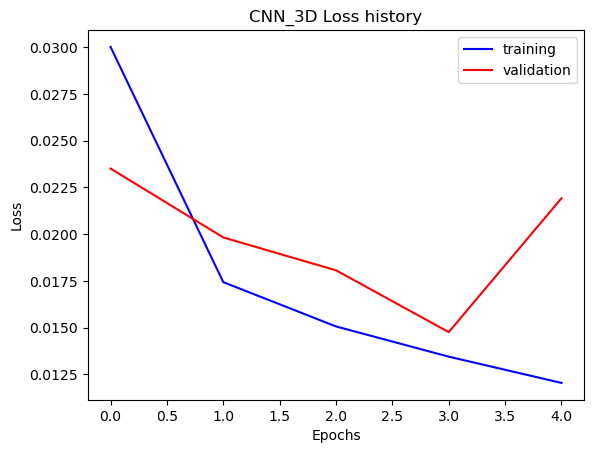

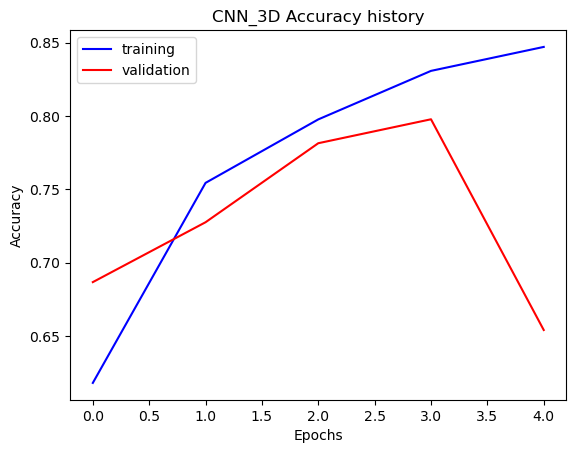

Train Accuracy = 0.8470012239172525; Validation Accuracy = 0.6541598695429075


In [20]:
cnn_trainer.plot_loss_history()
cnn_trainer.plot_accuracy()

cnn_train_accuracy = cnn_trainer.train_accuracy_history[-1]
cnn_validation_accuracy = cnn_trainer.validation_accuracy_history[-1]
print(
    "Train Accuracy = {}; Validation Accuracy = {}".format(
        cnn_train_accuracy, cnn_validation_accuracy
    )
)

In [21]:
save_trained_model_weights(model_cnn, out_dir=os.path.join(model_path, "CNN_3D"))
cnn_trainer.save_plots(path=results_path)

Saved training plots to ../src/models/CNN_3D/trained_CNN_3D_final.pt
Saved training plots to ../results/


# Step 2: Test ResNet Pretrained Model

In [22]:
inp_size = (224,224)

In [23]:
model_resnet = MyResNet(num_classes=num_classes)

resnet_optimizer_config = {"optimizer_type": "adam", "lr": 1e-3, "weight_decay": 1e-8} # Tune these
resnet_optimizer = get_optimizer(model_resnet, resnet_optimizer_config)

resnet_trainer = Trainer(
    data_dir=data_path,
    model=model_resnet,
    optimizer=resnet_optimizer,
    model_dir=os.path.join(model_path, "ResNet"),
    train_data_transforms=get_all_transforms(inp_size, [dataset_mean], [dataset_std]),
    val_data_transforms=get_fundamental_normalization_transforms(
        inp_size, [dataset_mean], [dataset_std]
    ),
    batch_size=batch_size,
    load_from_disk=False,
    cuda=torch.cuda.is_available(),
)

In [24]:
%%time
resnet_trainer.run_training_loop(num_epochs=5)

Minibatch:1 Train Loss:0.0319 Val Loss: 0.0319 Train Accuracy: 0.5000 Validation Accuracy: 0.5000
Minibatch:2 Train Loss:0.0373 Val Loss: 0.0373 Train Accuracy: 0.3438 Validation Accuracy: 0.3438
Minibatch:3 Train Loss:0.0330 Val Loss: 0.0330 Train Accuracy: 0.5000 Validation Accuracy: 0.5000
Minibatch:4 Train Loss:0.0301 Val Loss: 0.0301 Train Accuracy: 0.5000 Validation Accuracy: 0.5000
Minibatch:5 Train Loss:0.0339 Val Loss: 0.0339 Train Accuracy: 0.4688 Validation Accuracy: 0.4688
Minibatch:6 Train Loss:0.0312 Val Loss: 0.0312 Train Accuracy: 0.5312 Validation Accuracy: 0.5312
Minibatch:7 Train Loss:0.0314 Val Loss: 0.0314 Train Accuracy: 0.4688 Validation Accuracy: 0.4688
Minibatch:8 Train Loss:0.0343 Val Loss: 0.0343 Train Accuracy: 0.4375 Validation Accuracy: 0.4375
Minibatch:9 Train Loss:0.0309 Val Loss: 0.0309 Train Accuracy: 0.4375 Validation Accuracy: 0.4375
Minibatch:10 Train Loss:0.0316 Val Loss: 0.0316 Train Accuracy: 0.5625 Validation Accuracy: 0.5625
Minibatch:11 Train 

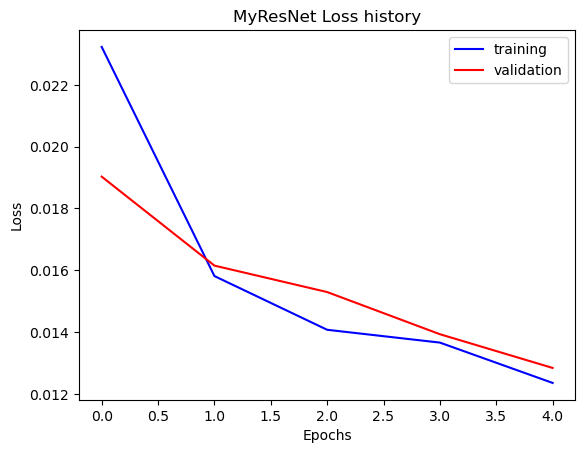

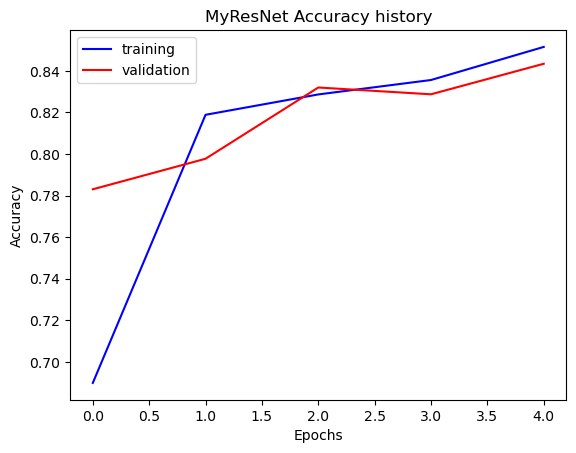

Train Accuracy = 0.8514891880135398; Validation Accuracy = 0.8433931484502447


In [25]:
resnet_trainer.plot_loss_history()
resnet_trainer.plot_accuracy()

resnet_train_accuracy = resnet_trainer.train_accuracy_history[-1]
resnet_validation_accuracy = resnet_trainer.validation_accuracy_history[-1]
print(
    "Train Accuracy = {}; Validation Accuracy = {}".format(
        resnet_train_accuracy, resnet_validation_accuracy
    )
)

In [26]:
save_trained_model_weights(model_resnet, out_dir=os.path.join(model_path, "ResNet"))
resnet_trainer.save_plots(path=results_path)

Saved training plots to ../src/models/ResNet/trained_MyResNet_final.pt
Saved training plots to ../results/


# Step 3: Test Inception Pretrained Model

In [27]:
inp_size = (299,299)

In [28]:
model_inception = MyInception(num_classes=num_classes)

inception_optimizer_config = {"optimizer_type": "adam", "lr": 1e-3, "weight_decay": 1e-8} # Tune these
inception_optimizer = get_optimizer(model_inception, inception_optimizer_config)

inception_trainer = Trainer(
    data_dir=data_path,
    model=model_inception,
    optimizer=inception_optimizer,
    model_dir=os.path.join(model_path, "Inception"),
    train_data_transforms=get_all_transforms(inp_size, [dataset_mean], [dataset_std]),
    val_data_transforms=get_fundamental_normalization_transforms(
        inp_size, [dataset_mean], [dataset_std]
    ),
    batch_size=batch_size,
    load_from_disk=False,
    cuda=torch.cuda.is_available(),
)

In [29]:
%%time
inception_trainer.run_training_loop(num_epochs=5)

Minibatch:1 Train Loss:0.0361 Val Loss: 0.0361 Train Accuracy: 0.3750 Validation Accuracy: 0.3750
Minibatch:2 Train Loss:0.0341 Val Loss: 0.0341 Train Accuracy: 0.4688 Validation Accuracy: 0.4688
Minibatch:3 Train Loss:0.0381 Val Loss: 0.0381 Train Accuracy: 0.3438 Validation Accuracy: 0.3438
Minibatch:4 Train Loss:0.0289 Val Loss: 0.0289 Train Accuracy: 0.5625 Validation Accuracy: 0.5625
Minibatch:5 Train Loss:0.0322 Val Loss: 0.0322 Train Accuracy: 0.5000 Validation Accuracy: 0.5000
Minibatch:6 Train Loss:0.0335 Val Loss: 0.0335 Train Accuracy: 0.4062 Validation Accuracy: 0.4062
Minibatch:7 Train Loss:0.0269 Val Loss: 0.0269 Train Accuracy: 0.6875 Validation Accuracy: 0.6875
Minibatch:8 Train Loss:0.0326 Val Loss: 0.0326 Train Accuracy: 0.4688 Validation Accuracy: 0.4688
Minibatch:9 Train Loss:0.0322 Val Loss: 0.0322 Train Accuracy: 0.5312 Validation Accuracy: 0.5312
Minibatch:10 Train Loss:0.0291 Val Loss: 0.0291 Train Accuracy: 0.5938 Validation Accuracy: 0.5938
Minibatch:11 Train 

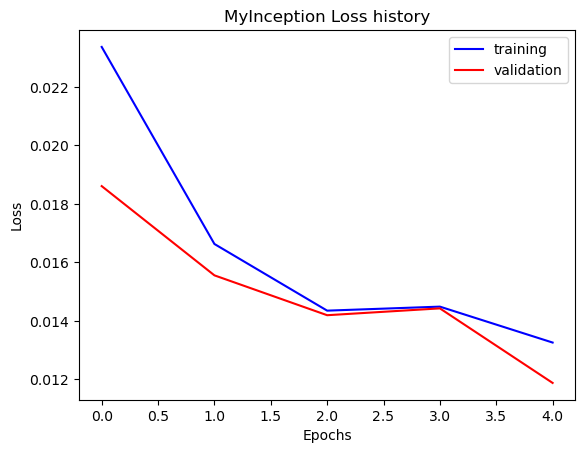

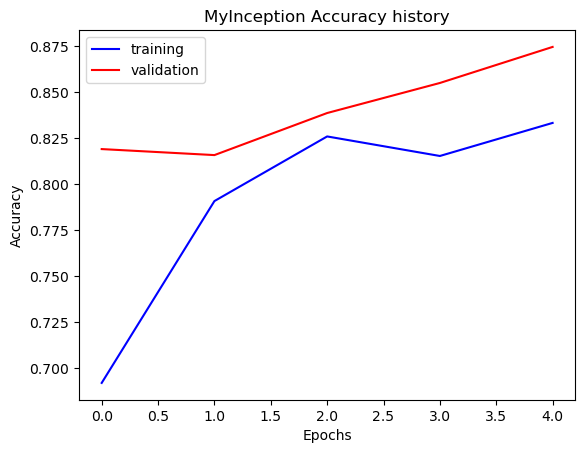

Train Accuracy = 0.8331293348437278; Validation Accuracy = 0.8743882544861338


In [30]:
inception_trainer.plot_loss_history()
inception_trainer.plot_accuracy()

inception_train_accuracy = inception_trainer.train_accuracy_history[-1]
inception_validation_accuracy = inception_trainer.validation_accuracy_history[-1]
print(
    "Train Accuracy = {}; Validation Accuracy = {}".format(
        inception_train_accuracy, inception_validation_accuracy
    )
)

In [31]:
save_trained_model_weights(model_inception, out_dir=os.path.join(model_path, "Inception"))
inception_trainer.save_plots(path=results_path)

Saved training plots to ../src/models/Inception/trained_MyInception_final.pt
Saved training plots to ../results/


# Step 4: Analyze Graphs and Final Accuracies

### Model Parameters

In [32]:
print('3D CNN:', model_cnn.count_parameters())
print('ResNet:', model_resnet.count_parameters())
print('Inception:', model_inception.count_parameters())

3D CNN: 1127063
ResNet: 11178051
Inception: 10761


### Loss & Accuracy Graphs

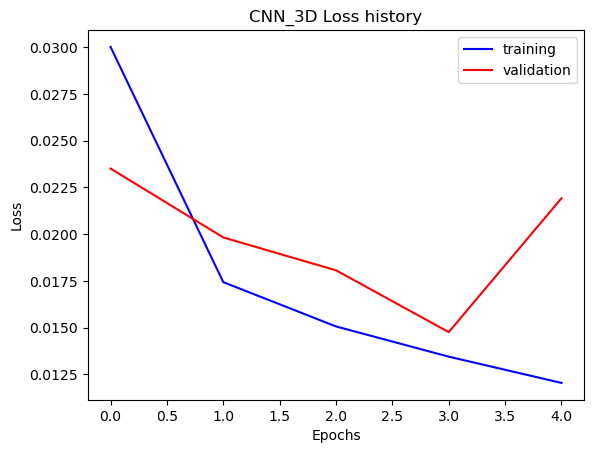

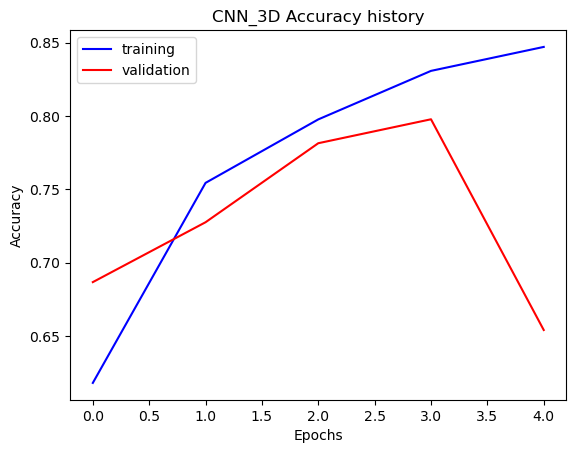

Train Accuracy = 0.8470012239172525; Validation Accuracy = 0.6541598695429075


In [33]:
cnn_trainer.plot_loss_history()
cnn_trainer.plot_accuracy()

cnn_train_accuracy = cnn_trainer.train_accuracy_history[-1]
cnn_validation_accuracy = cnn_trainer.validation_accuracy_history[-1]
print(
    "Train Accuracy = {}; Validation Accuracy = {}".format(
        cnn_train_accuracy, cnn_validation_accuracy
    )
)

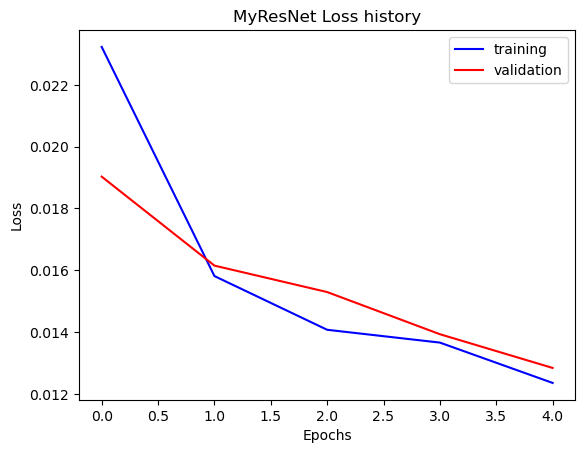

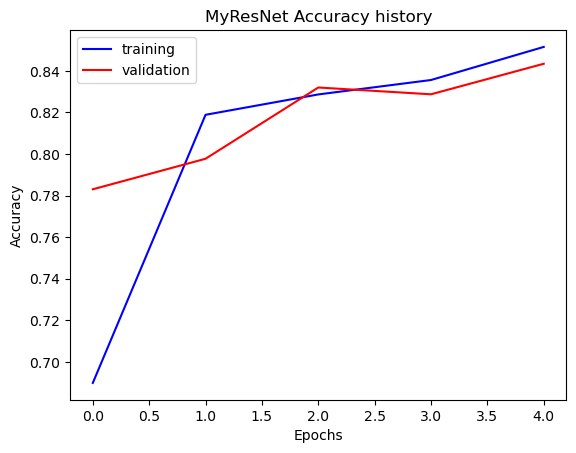

Train Accuracy = 0.8514891880135398; Validation Accuracy = 0.8433931484502447


In [34]:
resnet_trainer.plot_loss_history()
resnet_trainer.plot_accuracy()

resnet_train_accuracy = resnet_trainer.train_accuracy_history[-1]
resnet_validation_accuracy = resnet_trainer.validation_accuracy_history[-1]
print(
    "Train Accuracy = {}; Validation Accuracy = {}".format(
        resnet_train_accuracy, resnet_validation_accuracy
    )
)

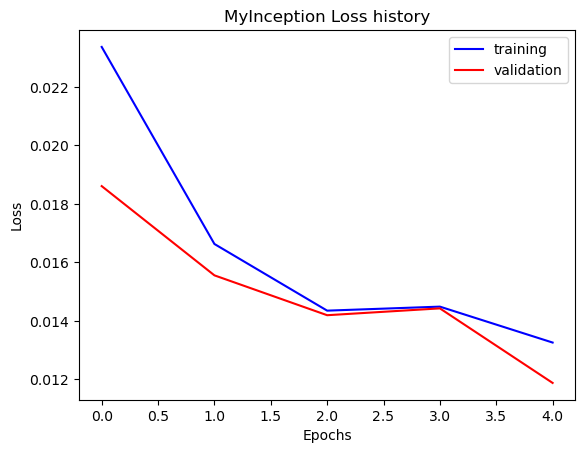

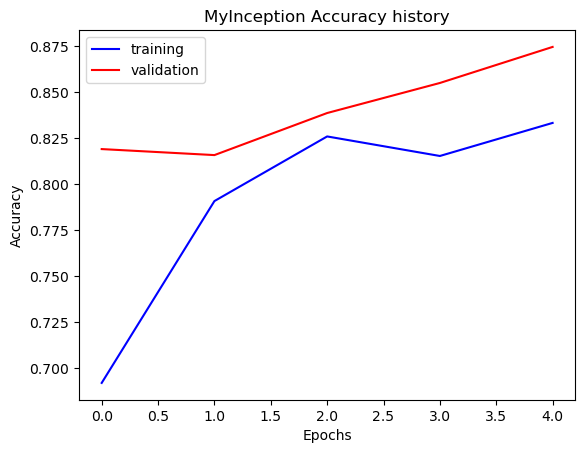

Train Accuracy = 0.8331293348437278; Validation Accuracy = 0.8743882544861338


In [35]:
inception_trainer.plot_loss_history()
inception_trainer.plot_accuracy()

inception_train_accuracy = inception_trainer.train_accuracy_history[-1]
inception_validation_accuracy = inception_trainer.validation_accuracy_history[-1]
print(
    "Train Accuracy = {}; Validation Accuracy = {}".format(
        inception_train_accuracy, inception_validation_accuracy
    )
)

### Confusion Matrices

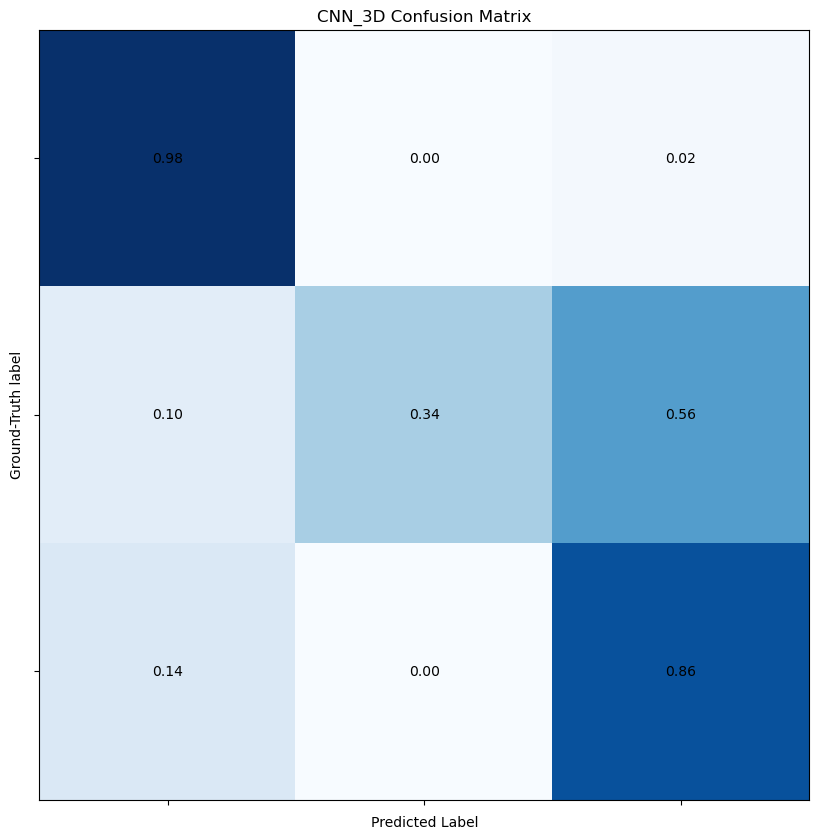

In [40]:
generate_and_plot_confusion_matrix(model_cnn, cnn_trainer.val_dataset, path=results_path, use_cuda=torch.cuda.is_available())

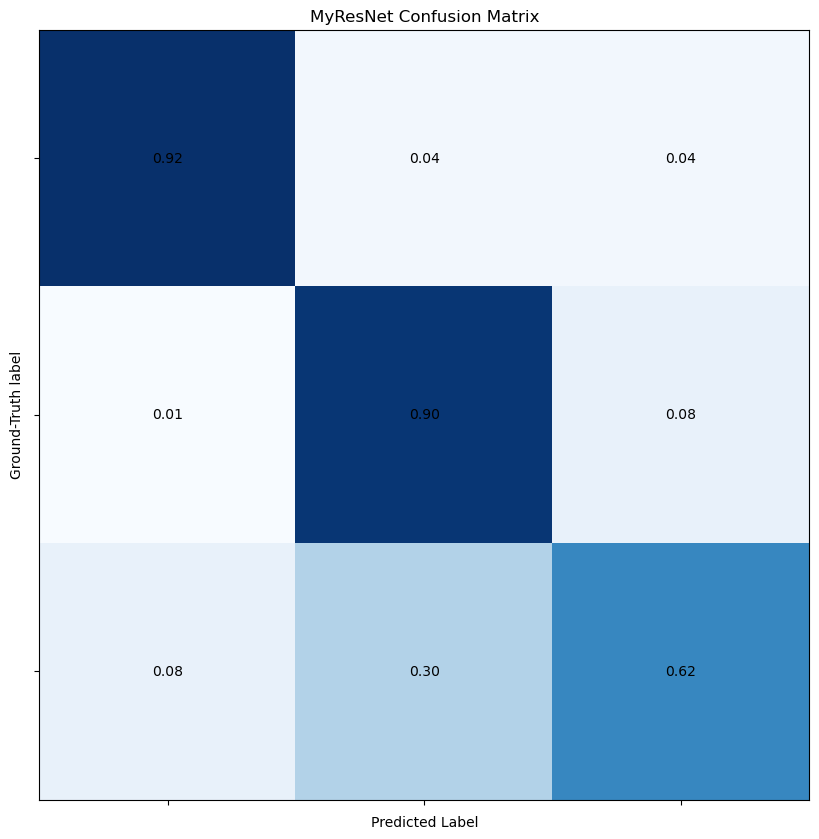

In [41]:
generate_and_plot_confusion_matrix(model_resnet, resnet_trainer.val_dataset, path=results_path, use_cuda=torch.cuda.is_available())

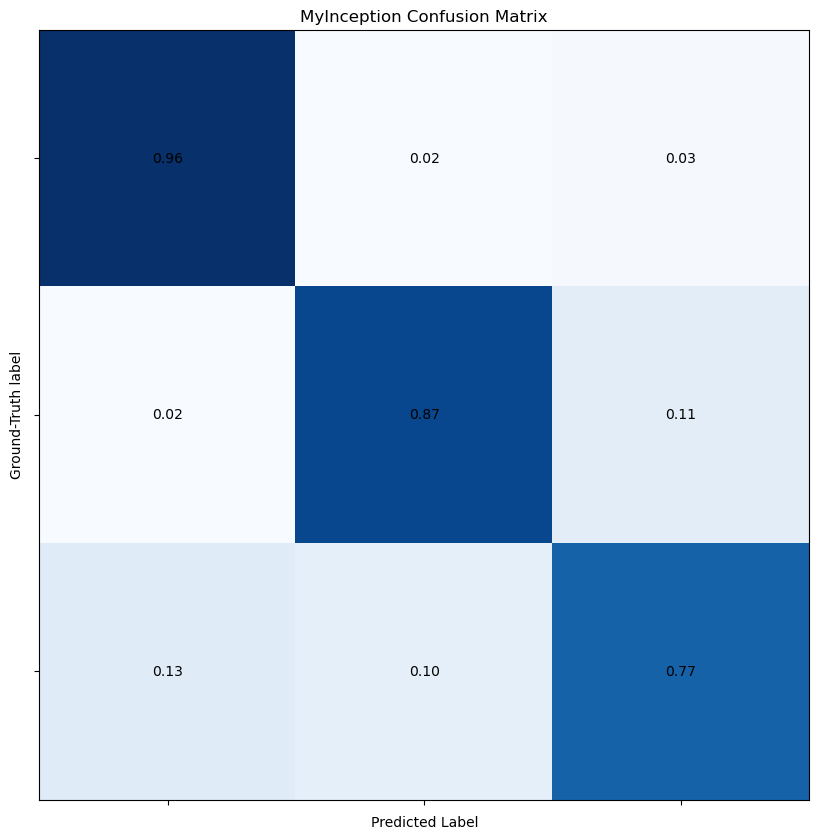

In [42]:
generate_and_plot_confusion_matrix(model_inception, inception_trainer.val_dataset, path=results_path, use_cuda=torch.cuda.is_available())

### Analyze errors that occurred from confusion matrix

{'Glioma': 0, 'Meningioma': 1, 'Pituitary': 2}


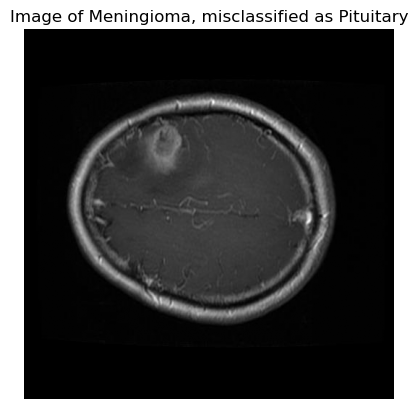

In [44]:
trainer = cnn_trainer # Change this
model = model_cnn # Change this

# Analyze confusion matrix and change these to observe results
predicted_class_num = 2
true_class_num = 1

correct_class = [k for k, v in trainer.val_dataset.class_dict.items() if v == true_class_num][0]
pred_class = key = [k for k, v in trainer.val_dataset.class_dict.items() if v == predicted_class_num][0]
print(trainer.val_dataset.class_dict)

paths = get_pred_images_for_target(model, trainer.val_dataset, predicted_class_num, true_class_num, torch.cuda.is_available())
max_count = 1
count = 0
for path in paths:
    img = Image.open(path).convert(mode='L')
    if (count != max_count):
        plt.imshow(img, cmap='gray')
        plt.title(f'Image of {correct_class}, misclassified as {pred_class}')
        plt.axis('off')  # Removes axis ticks
        plt.savefig(os.path.join(results_path, f'{model.__class__.__name__}_misclassified.png'))
        plt.show()
        count += 1